### PaddleOCR Only

In [15]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
import requests
import pandas as pd
from shapely import Polygon
import json

In [18]:
document_id = 5

In [17]:
samples_list = ["0","1"]

In [65]:
ocr = PaddleOCR(use_angle_cls=True, lang='en', det=True, rec=True, use_gpu=False)  # Set rec=False to disable text recognition

[2024/12/11 17:57:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/volpea/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/volpea/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_

In [94]:
with open(f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_{document_id}/sample_labels.json") as file:
    box_labels = json.load(file)

box_results = []

for sample_id in samples_list:
    print(f"---- sample {sample_id} ----")
    box_labels_df = pd.DataFrame(list(filter(lambda x: x["sample_id"] == int(sample_id), box_labels))[0]["boxes_labels"])
    box_labels_df = box_labels_df.rename(columns={"generated_string": "label_text", "label_box_positon": "position"})

    image_path = f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_{document_id}/sample_{sample_id}.png"
    results = ocr.ocr(image_path, det=True, rec=True)
    detected_boxes = results[0]

    print(f"detected_boxes: {len(detected_boxes)}")

    detected_colliding_boxes = []
    for detected_box in detected_boxes:
        for _, l_box in box_labels_df.iterrows():
            intersection_area = Polygon(detected_box[0]).intersection(Polygon(l_box["position"])).area
            label_area = Polygon(l_box["position"]).area
            detected_box_area = Polygon(detected_box[0]).area
            
            if intersection_area > 0:
                detected_colliding_boxes.append({"box_id": l_box["box_id"],
                                                 "detected_box_position": detected_box[0],
                                                 "detected_box_text": detected_box[1][0],
                                                 "detected_box_text_confidence": detected_box[1][1],
                                                 "intersection_recall": intersection_area / label_area,
                                                 "intersection_precision": intersection_area / detected_box_area})

    print(f"detected_boxes: {len(detected_colliding_boxes)}")

    detected_colliding_boxes = pd.DataFrame(detected_colliding_boxes) \
                                .sort_values(by=["intersection_precision", "intersection_recall"], ascending=False) \
                                .drop_duplicates(subset="box_id")

    detected_colliding_boxes["sample_id"] = sample_id

    res = box_labels_df.merge(detected_colliding_boxes, on="box_id", how="left")
    
    box_results.append(res)

---- sample 0 ----
[2024/12/11 18:07:03] ppocr DEBUG: dt_boxes num : 186, elapsed : 0.2018418312072754
[2024/12/11 18:07:04] ppocr DEBUG: cls num  : 186, elapsed : 0.7715575695037842
[2024/12/11 18:07:32] ppocr DEBUG: rec_res num  : 186, elapsed : 28.441932678222656
detected_boxes: 180
detected_boxes: 2
---- sample 1 ----
[2024/12/11 18:07:33] ppocr DEBUG: dt_boxes num : 184, elapsed : 0.2224869728088379
[2024/12/11 18:07:33] ppocr DEBUG: cls num  : 184, elapsed : 0.7697701454162598
[2024/12/11 18:08:01] ppocr DEBUG: rec_res num  : 184, elapsed : 27.591830015182495
detected_boxes: 180
detected_boxes: 2


In [96]:
box_results = pd.concat(box_results)

In [97]:
box_results.head(3)

,box_id,box_name,label_text,position,detected_box_position,detected_box_text,detected_box_text_confidence,intersection_recall,intersection_precision,sample_id
0,13,test_cognome,0311908,"[[497, 167], [574, 167], [574, 186], [497, 186]]",NaN,NaN,NaN,NaN,NaN,NaN
1,14,cognome_a,JUJEMVNBCK,"[[58, 172], [191, 172], [191, 189], [58, 189]]","[[5.0, 171.0], [192.0, 167.0], [192.0, 189.0],...",CognomeJUJEMVNBCK,0.980957,1.00000,0.56363,0
2,15,veicolo,ZXJDKIZALKY,"[[508, 286], [673, 286], [673, 303], [508, 303]]","[[510.0, 288.0], [672.0, 288.0], [672.0, 303.0...",ZXJDRIZALRY,0.874332,0.86631,1.00000,0


In [100]:
box_results["detected"] = False
box_results.loc[~box_results["detected_box_text"].isnull(), "detected"] = True

In [98]:
box_results["string_match"] = False
box_results.loc[box_results["detected_box_text"] == box_results["label_text"], "string_match"] = True

In [101]:
box_results["detected"].value_counts()

detected
True     4
False    2
Name: count, dtype: int64

In [102]:
box_results["string_match"].value_counts()

string_match
False    5
True     1
Name: count, dtype: int64

In [ ]:
# Load image
image_path = f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_{document_id}/sample_{sample_id}.png"
image = Image.open(image_path)

In [ ]:
with open(f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_{document_id}/sample_labels.json") as file:
    box_labels = json.load(file)

In [93]:
box_labels_df = pd.DataFrame(list(filter(lambda x: x["sample_id"] == int(sample_id), box_labels))[0]["boxes_labels"])

In [78]:
results = ocr.ocr(image_path, det=True, rec=True)

[2024/12/11 18:02:29] ppocr DEBUG: dt_boxes num : 186, elapsed : 0.21351289749145508
[2024/12/11 18:02:30] ppocr DEBUG: cls num  : 186, elapsed : 0.8140780925750732
[2024/12/11 18:02:59] ppocr DEBUG: rec_res num  : 186, elapsed : 28.728140115737915


In [79]:
detected_boxes = results[0]

In [80]:
len(detected_boxes)

182

In [81]:
detected_colliding_boxes = []

for detected_box in detected_boxes:
    for _, l_box in box_labels.iterrows():
        intersection_area = Polygon(detected_box[0]).intersection(Polygon(l_box["position"])).area
        label_area = Polygon(l_box["position"]).area
        detected_box_area = Polygon(detected_box[0]).area
        if intersection_area > 0:
            detected_colliding_boxes.append({"box_id": l_box["box_id"],
                                             "box_name": l_box["box_name"],
                                             "detected_box_position": detected_box[0],
                                             "detected_box_text": detected_box[1][0],
                                             "detected_box_text_confidence": detected_box[1][1],
                                             "label_box_positon": l_box["position"],
                                             "label_text": l_box["generated_string"],
                                             "intersection_recall": intersection_area / label_area,
                                             "intersection_precision": intersection_area / detected_box_area})

In [82]:
len(detected_colliding_boxes)

3

In [83]:
detected_colliding_boxes = pd.DataFrame(detected_colliding_boxes) \
                            .sort_values(by=["intersection_precision", "intersection_recall"], ascending=False) \
                            .drop_duplicates(subset="box_id")

In [84]:
detected_colliding_boxes

,box_id,box_name,detected_box_position,detected_box_text,detected_box_text_confidence,label_box_positon,label_text,intersection_recall,intersection_precision
2,15,veicolo,"[[504.0, 283.0], [646.0, 287.0], [645.0, 309.0...",HNOEQOZG,0.994098,"[[508, 286], [673, 286], [673, 304], [508, 304]]",DLQEVEZSRZ,0.828176,0.769011
0,14,cognome_a,"[[4.0, 168.0], [205.0, 164.0], [205.0, 190.0],...",CognomeRRYNOGOFOFR,0.981251,"[[58, 172], [177, 172], [177, 189], [58, 189]]",JVMWDEUMS,1.000000,0.395542
1,13,test_cognome,"[[466.0, 164.0], [501.0, 164.0], [501.0, 172.0...",(dere,0.665652,"[[497, 167], [616, 167], [616, 186], [497, 186]]",77984434,0.008846,0.071429


In [85]:
image_with_boxes = draw_ocr(image, detected_colliding_boxes["detected_box_position"].to_list())
image_with_boxes = Image.fromarray(image_with_boxes)

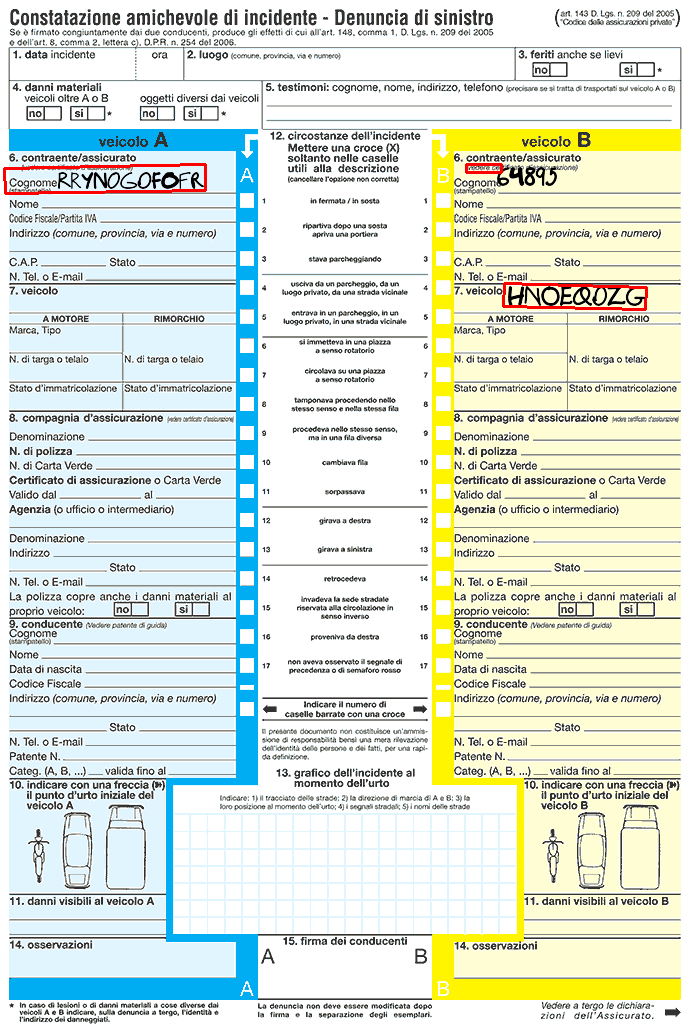

In [86]:
image_with_boxes

In [26]:
detected_colliding_boxes["string_match"] = False

In [34]:
detected_colliding_boxes.loc[detected_colliding_boxes["detected_box_text"] == detected_colliding_boxes["label_text"], "string_match"] = True

In [37]:
detected_colliding_boxes["match"].value_counts()

match
True     1
False    1
Name: count, dtype: int64